## This is essentially a copy of the RL intro from Handson ML
(not original work)

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
obs = env.reset()

In [4]:
obs

array([0.02466058, 0.02109185, 0.02066387, 0.01463955])

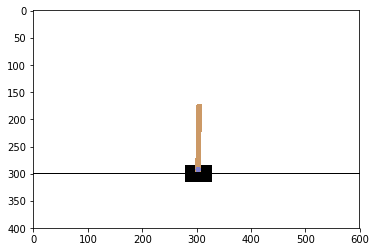

In [5]:
def plot_env():
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.show()

In [6]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): # 1000 steps max, we don't want to run forever
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

### Try with neural network

In [10]:
import tensorflow as tf

/home/austin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
tf.reset_default_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use the retry module or similar alternatives.


In [12]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
            for discounted_rewards in all_discounted_rewards]

In [15]:
>>> discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [14]:
>>> discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [16]:
n_iterations = 250      # number of training iterations
n_max_steps = 1000      # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 10    # save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = []    # all sequences of raw rewards for each episode
        all_gradients = []  # gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = []   # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run(
                        [action, gradients],
                        feed_dict={X: obs.reshape(1, n_inputs)}) # one obs
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards,discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean(
                [reward * all_gradients[game_index][step][var_index]
                    for game_index, rewards in enumerate(all_rewards)
                    for step, reward in enumerate(rewards)],
                axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./models/my_policy_net_pg.ckpt")